In [1]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt

In [2]:
import numpy as np
import pandas as pd

np.random.seed(21)

# Mendefinisikan Parameter
A_initial = 265  # Total Produk Terjual
a = [[1, 1],
     [1, 1]]

initial_prices = np.array([80, 74])  # Harga Awal
max_steps = 20  # Banyak Step
buyer_value = 100  # Nilai kepuasan untuk perhitungan utilitas

# Inisiasi Harga dan variabel lain
p = initial_prices.copy()
num_sellers = len(a)  # Banyak Seller
columns = ['Step'] + [f'Harga_Penjual_{i + 1}' for i in range(num_sellers)] + \
          [f'Demand_Penjual_{i + 1}' for i in range(num_sellers)] + \
          [f'Revenue_Penjual_{i + 1}' for i in range(num_sellers)] + \
          [f'Utilitas_Pembeli_untuk_Penjual_{i + 1}' for i in range(num_sellers)] + \
          ['Keputusan_Pembeli', 'Utilitas_Pembeli']
simulation_data = []
A = A_initial
total_revenues = np.zeros(num_sellers)
equilibrium_reached = False
equilibrium_step = -1

# Harga historis untuk prediksi utilitas
historical_prices = [[] for _ in range(num_sellers)]

for step in range(max_steps):
    new_p = p.copy()
    demands = []
    revenues = []
    utilities_buyer_to_seller = []

    # Menghitung Permintaan (Demand) dan Pendapatan
    for i in range(num_sellers):
        other_prices_sum = sum(a[i][j] * p[j] for j in range(num_sellers) if j != i)
        if p[i] < min(p[j] for j in range(num_sellers) if j != i):
            q_i = A - a[i][i] * p[i] + other_prices_sum
        elif p[i] > min(p[j] for j in range(num_sellers) if j != i):
            q_i = 0
        else:
            q_i = (A - a[i][i] * p[i] + other_prices_sum) / num_sellers
        
        demands.append(q_i)
        
        # Menghitung Utilitas Pembeli kepada Penjual
        utility_buyer_to_seller_i = buyer_value - p[i]
        utilities_buyer_to_seller.append(utility_buyer_to_seller_i)

    # Keputusan Pembeli berdasarkan utilitas
    max_utility_index = np.argmax(utilities_buyer_to_seller)
    max_utility_value = utilities_buyer_to_seller[max_utility_index]
    
    # Harga historis untuk prediksi Utilitas
    for i in range(num_sellers):
        historical_prices[i].append(p[i])
        if len(historical_prices[i]) > 3:
            historical_prices[i].pop(0)

    # Keputusan Pembeli berdasarkan utilitas saat ini dan prediksi utilitas di masa depan
    current_utilities = utilities_buyer_to_seller
    predictions = [np.mean(historical_prices[i][-3:]) for i in range(num_sellers)]
    future_utilities = [buyer_value - prediction for prediction in predictions]

    max_current_utility = max(current_utilities)
    max_future_utility = max(future_utilities)

    if max_current_utility >= max_future_utility:
        decision = max_utility_index
        buyer_decision = f"Beli dari Penjual {decision + 1} dengan harga {p[decision]}."
        buyer_utility = f"Utilitas: {current_utilities[decision]}"
        
        # Hitung pendapatan ketika membeli
        for i in range(num_sellers):
            if np.all(p == p[0]):
                revenues.append(demands[i] * p[i])
            else:
                if p[i] == min(p):
                    revenues.append(p[i])
                else:
                    revenues.append(0)
        
    else:
        decision = 'tunggu'
        buyer_decision = "Pembeli memutuskan untuk menunggu."
        buyer_utility = f"Utilitas di Masa Depan: {max(future_utilities)}"

        # Set pendapatan menjadi 0 ketika pembeli memutuskan untuk menunggu
        revenues = [0] * num_sellers
    total_revenues += revenues
    simulation_data.append([step] + list(new_p) + demands + revenues + utilities_buyer_to_seller + [buyer_decision, buyer_utility])

    # Pemilihan Harga
    for i in range(num_sellers):
        if demands[i] > A:  # Jika Permintaan melebihi Persediaan
            if p[i] == min(p):  # Jika harga p_i < min(p_j)
                max_increment = max(p) - p[i] + 1  # Rentang perbedaan harga
                if max_increment > 0:
                    increment = np.random.randint(1, max_increment + 1)
                    new_p[i] += increment
        elif demands[i] == 0:  # Jika tidak ada permintaan
            max_decrement = p[i] - min(p) + 1
            if max_decrement > 0:
                decrement = np.random.randint(1, max_decrement + 1)
                new_p[i] -= decrement

    # Membulatkan harga
    new_p = np.round(new_p, 2)

    # Periksa keseimbangan
    if np.all(new_p == new_p[0]):
        if equilibrium_reached:
            break
        equilibrium_reached = True
        equilibrium_step = step

    p = new_p.copy()
    A -= 1  # Mengurangi stok barang sebanyak 1

df_simulation = pd.DataFrame(simulation_data, columns=columns)

print("Harga Akhir:", p)
print("Total Pendapatan:", total_revenues)
# Tampilkan DataFrame simulasi
print(df_simulation)

Harga Akhir: [76 76]
Total Pendapatan: [9915. 9994.]
    Step  Harga_Penjual_1  Harga_Penjual_2  Demand_Penjual_1  \
0      0               80               74               0.0   
1      1               78               75               0.0   
2      2               77               76               0.0   
3      3               76               77             263.0   
4      4               78               76               0.0   
5      5               75               78             263.0   
6      6               78               77               0.0   
7      7               77               79             260.0   
8      8               78               77               0.0   
9      9               76               79             259.0   
10    10               78               76               0.0   
11    11               75               77             256.0   
12    12               78               76               0.0   
13    13               75               77         

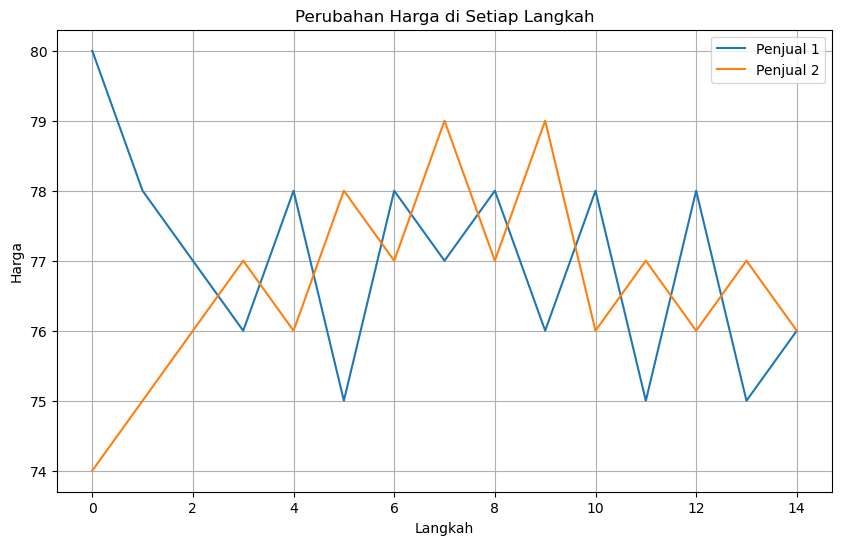

In [3]:
plt.figure(figsize=(10, 6))
for i in range(num_sellers):
    plt.plot(df_simulation['Step'], df_simulation[f'Harga_Penjual_{i+1}'], label=f'Penjual {i+1}')

plt.xlabel('Langkah')
plt.ylabel('Harga')
plt.title('Perubahan Harga di Setiap Langkah')
plt.legend()
plt.grid(True)

plt.savefig('Perubahan Harga di Setiap Langkah (Pembeli).png')
plt.show()

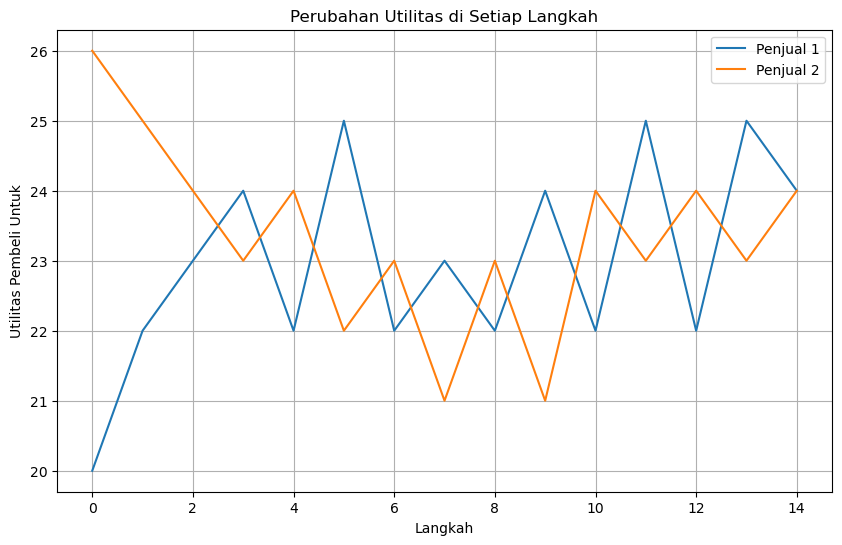

In [4]:
plt.figure(figsize=(10, 6))
for i in range(num_sellers):
    plt.plot(df_simulation['Step'], df_simulation[f'Utilitas_Pembeli_untuk_Penjual_{i + 1}'], label=f'Penjual {i+1}')

plt.xlabel('Langkah')
plt.ylabel('Utilitas Pembeli Untuk')
plt.title('Perubahan Utilitas di Setiap Langkah')
plt.legend()
plt.grid(True)

plt.savefig('Perubahan Utilitas di Setiap Langkah (Pembeli).png')
plt.show()

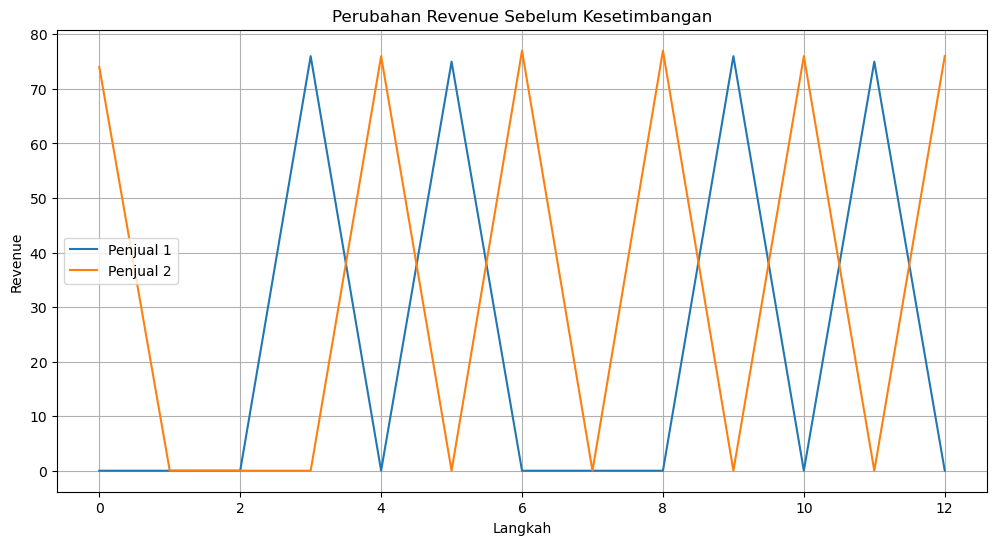

In [5]:
plt.figure(figsize=(12, 6))
for i in range(num_sellers):
    plt.plot(df_simulation['Step'][:13], df_simulation[f'Revenue_Penjual_{i + 1}'][:13], label=f'Penjual {i+1}')

plt.xlabel('Langkah')
plt.ylabel('Revenue')
plt.title('Perubahan Revenue Sebelum Kesetimbangan')
plt.legend()
plt.grid(True)
plt.savefig('Perubahan Revenue Sebelum Kesetimbangan (Pembeli).png')
plt.show()

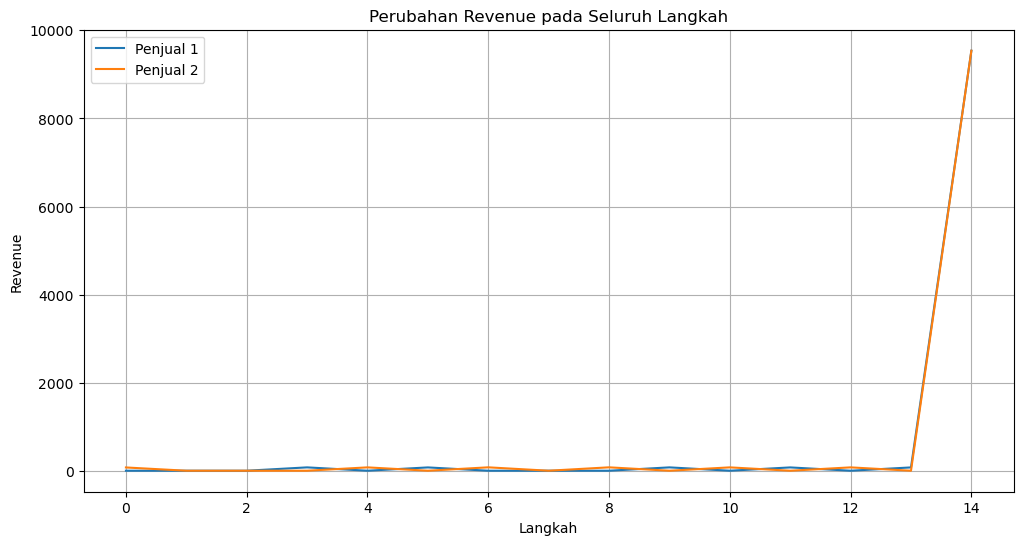

In [6]:
plt.figure(figsize=(12, 6))
for i in range(num_sellers):
    plt.plot(df_simulation['Step'], df_simulation[f'Revenue_Penjual_{i + 1}'], label=f'Penjual {i+1}')

plt.xlabel('Langkah')
plt.ylabel('Revenue')
plt.title('Perubahan Revenue pada Seluruh Langkah')
plt.legend()
plt.grid(True)
plt.savefig('Perubahan Revenue pada setiap Langkah (Pembeli).png')
plt.show()

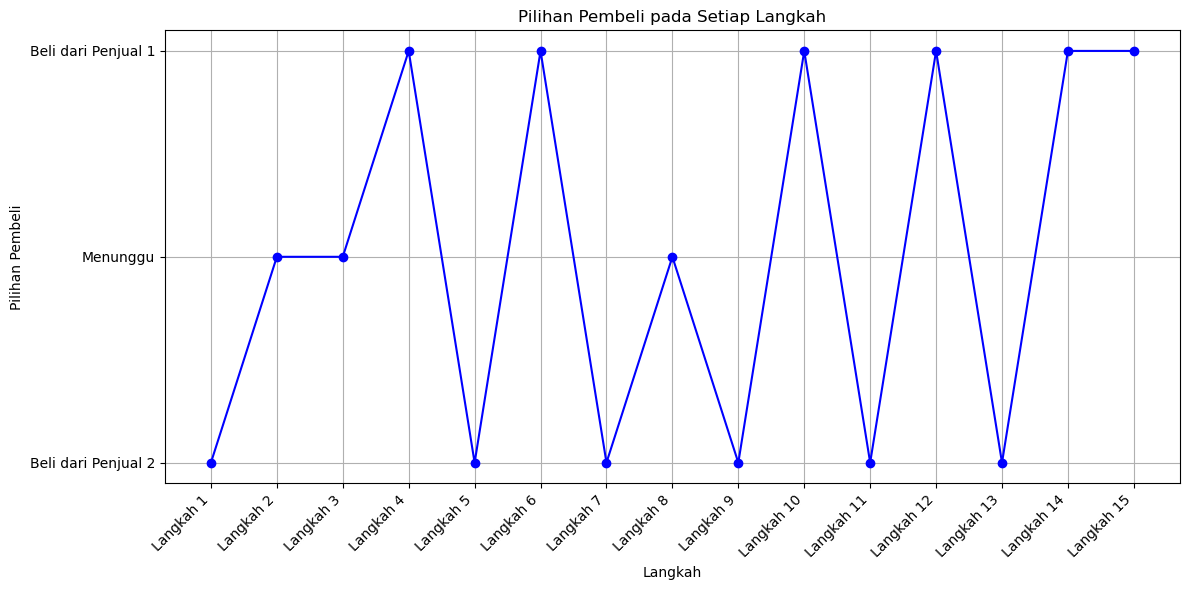

In [7]:
# Hitung jumlah keputusan
decision_counts = df_simulation['Keputusan_Pembeli'].value_counts()

# Proses data untuk mendapatkan pilihan pembeli pada setiap langkah
langkah = []
pilihan = []

for idx, row in df_simulation.iterrows():
    langkah.append(f'Langkah {idx + 1}')
    if 'Beli' in row['Keputusan_Pembeli']:
        pilihan.append(row['Keputusan_Pembeli'].split(' dengan ')[0])
    else:
        pilihan.append('Menunggu')

# Plot grafik
plt.figure(figsize=(12, 6))
plt.plot(langkah, pilihan, marker='o', linestyle='-', color='b')
plt.title('Pilihan Pembeli pada Setiap Langkah')
plt.xlabel('Langkah')
plt.ylabel('Pilihan Pembeli')
plt.xticks(rotation=45, ha='right')
plt.grid(True)
plt.tight_layout()
plt.savefig('Keputusan Pembeli.png')
plt.show()